## Code to detect marine heat waves. These codes are inspired from this [tutorial](https://surftemp.github.io/sst-data-tutorials/tutorial2.html).
#### Created by: Ligin Joseph


In [2]:
import fsspec
import xarray as xr
import matplotlib
import numpy as np
import datetime

In [3]:
## open file
ds = xr.open_dataset('../Data/Observations/OISST/OISST_1d_SST_AS_1982_2024_aug.nc').sel(time=slice('1982','2023'))
sst=ds.sst

In [4]:
sst

<xarray.DataArray 'sst' (time: 15623, lat: 120, lon: 160)> Size: 1GB
[299961600 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 125kB 1982-01-01T12:00:00 ... 2023-12-31T1...
  * lon      (lon) float32 640B 40.12 40.38 40.62 40.88 ... 79.38 79.62 79.88
  * lat      (lat) float32 480B 5.125 5.375 5.625 5.875 ... 34.38 34.62 34.88
    zlev     float32 4B ...
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius

### Climatology

In [8]:
## Define base period 
climatology_start = "1982-01-01"
climatology_end = "2011-12-31"
climatology_raw_data = sst.sel(time=slice(climatology_start,climatology_end))

In [10]:
## Compute rolling mean
climatology_rolling = climatology_raw_data.chunk({"lat": 10, "lon": 10, "time":-1}).pad(pad_width={"time":5},mode="wrap").rolling(time=11,center=True).construct("window").isel(time=slice(5,-5))

In [12]:
## Compute 90th percentile
climatology_90th_percentile = climatology_rolling.chunk({"time":-1}).groupby("time.dayofyear").quantile(0.9,dim=["time","window"]).load()

C:\Users\li3n23\miniforge3\envs\work_CMIP\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [13]:
## Apply binomial smoothening
binomial_coefficients = (np.poly1d([0.5, 0.5]) ** 30).coeffs
climatology_90th_percentile_smoothed = (climatology_90th_percentile \
    .pad(pad_width={"dayofyear":15},mode="wrap")                                    
    .rolling(dayofyear=31,center=True) \
    .construct("window") \
    .isel(dayofyear=slice(15,-15)) \
    * binomial_coefficients).sum(axis=-1,skipna=False)

In [14]:
## Save climatology to a netcdf file.
climatology_90th_percentile_smoothed.to_netcdf('climatology_90th_percentile_smoothed.nc')

### MHW detection

In [5]:
## Open the climatology file
climatology_90th_percentile_smoothed=xr.open_dataset('climatology_90th_percentile_smoothed.nc').sst

In [11]:
period = ("1982-01-01", "2024-01-01")   ## Define the period during which MHWs to be detected

time_window_days = 5    ## Number of consecutive days to be considered as MHW

# Convert period to datetime
start_date = datetime.datetime.strptime(period[0], "%Y-%m-%d")
end_date = datetime.datetime.strptime(period[1], "%Y-%m-%d")

# # Widen the time range by +/- time_window_days to deal with values at edges
# data_start_date = start_date - datetime.timedelta(days=time_window_days)
# data_end_date = end_date + datetime.timedelta(days=time_window_days)

# Load the sea surface temperature data for the widened time range
sst_data = sst.sel(time=slice(start_date, end_date)).load()

# Create a DataArray with dayofyear
sst_data["dayofyear"] = sst_data.time.dt.dayofyear

# Dimensions
n_lats = len(sst_data.lat)
n_lons = len(sst_data.lon)
n_days = len(sst_data.time)

# Create arrays to hold counts and flags
hot_day_count = np.zeros(shape=(n_lats, n_lons))
mhw_flags = np.zeros(shape=(n_days, n_lats, n_lons))


In [12]:
np.shape(mhw_flags)

(15623, 120, 160)

In [1]:
# Loop through each time step in the data
for t in range(n_days):
    dayofyear = sst_data["dayofyear"].values[t]
    
    # Update the hot_day_count for this time step, if condition is met, hot day count is incrimented by 1
    hot_day_count = np.where(
        sst_data.sel(time=sst_data.time[t]) > climatology_90th_percentile_smoothed.sel(dayofyear=dayofyear),
        hot_day_count + 1,
        0
    )
    
    # Identify marine heatwaves
    mhw = hot_day_count >= time_window_days
    
    # Flag the current day and preceding days, if the condition is met for 5 consecutive days or more, fill the preious days with 1
    for prev in range(max(0, t - time_window_days + 1), t + 1):
        mhw_flags[prev, :, :] = np.where(mhw, 1, mhw_flags[prev, :, :])


In [7]:
# Handle NaNs in the SST data, make mhw_flag also nan when SST is Nan.
mhw_flags = np.where(np.isnan(sst_data), np.nan, mhw_flags)

# Create the DataArray for marine heatwaves
mhw = xr.DataArray(
    data=mhw_flags,
    dims=["time", "lat", "lon"],
    coords={"time": sst_data.time, "lat": sst_data.lat, "lon": sst_data.lon}
)

# Clip the dataset back to the original time period
mhw = mhw.sel(time=slice(start_date, end_date))


In [8]:
## Save the MHW data to ncfile
mhw.to_netcdf('mhw_1982_2023.nc')

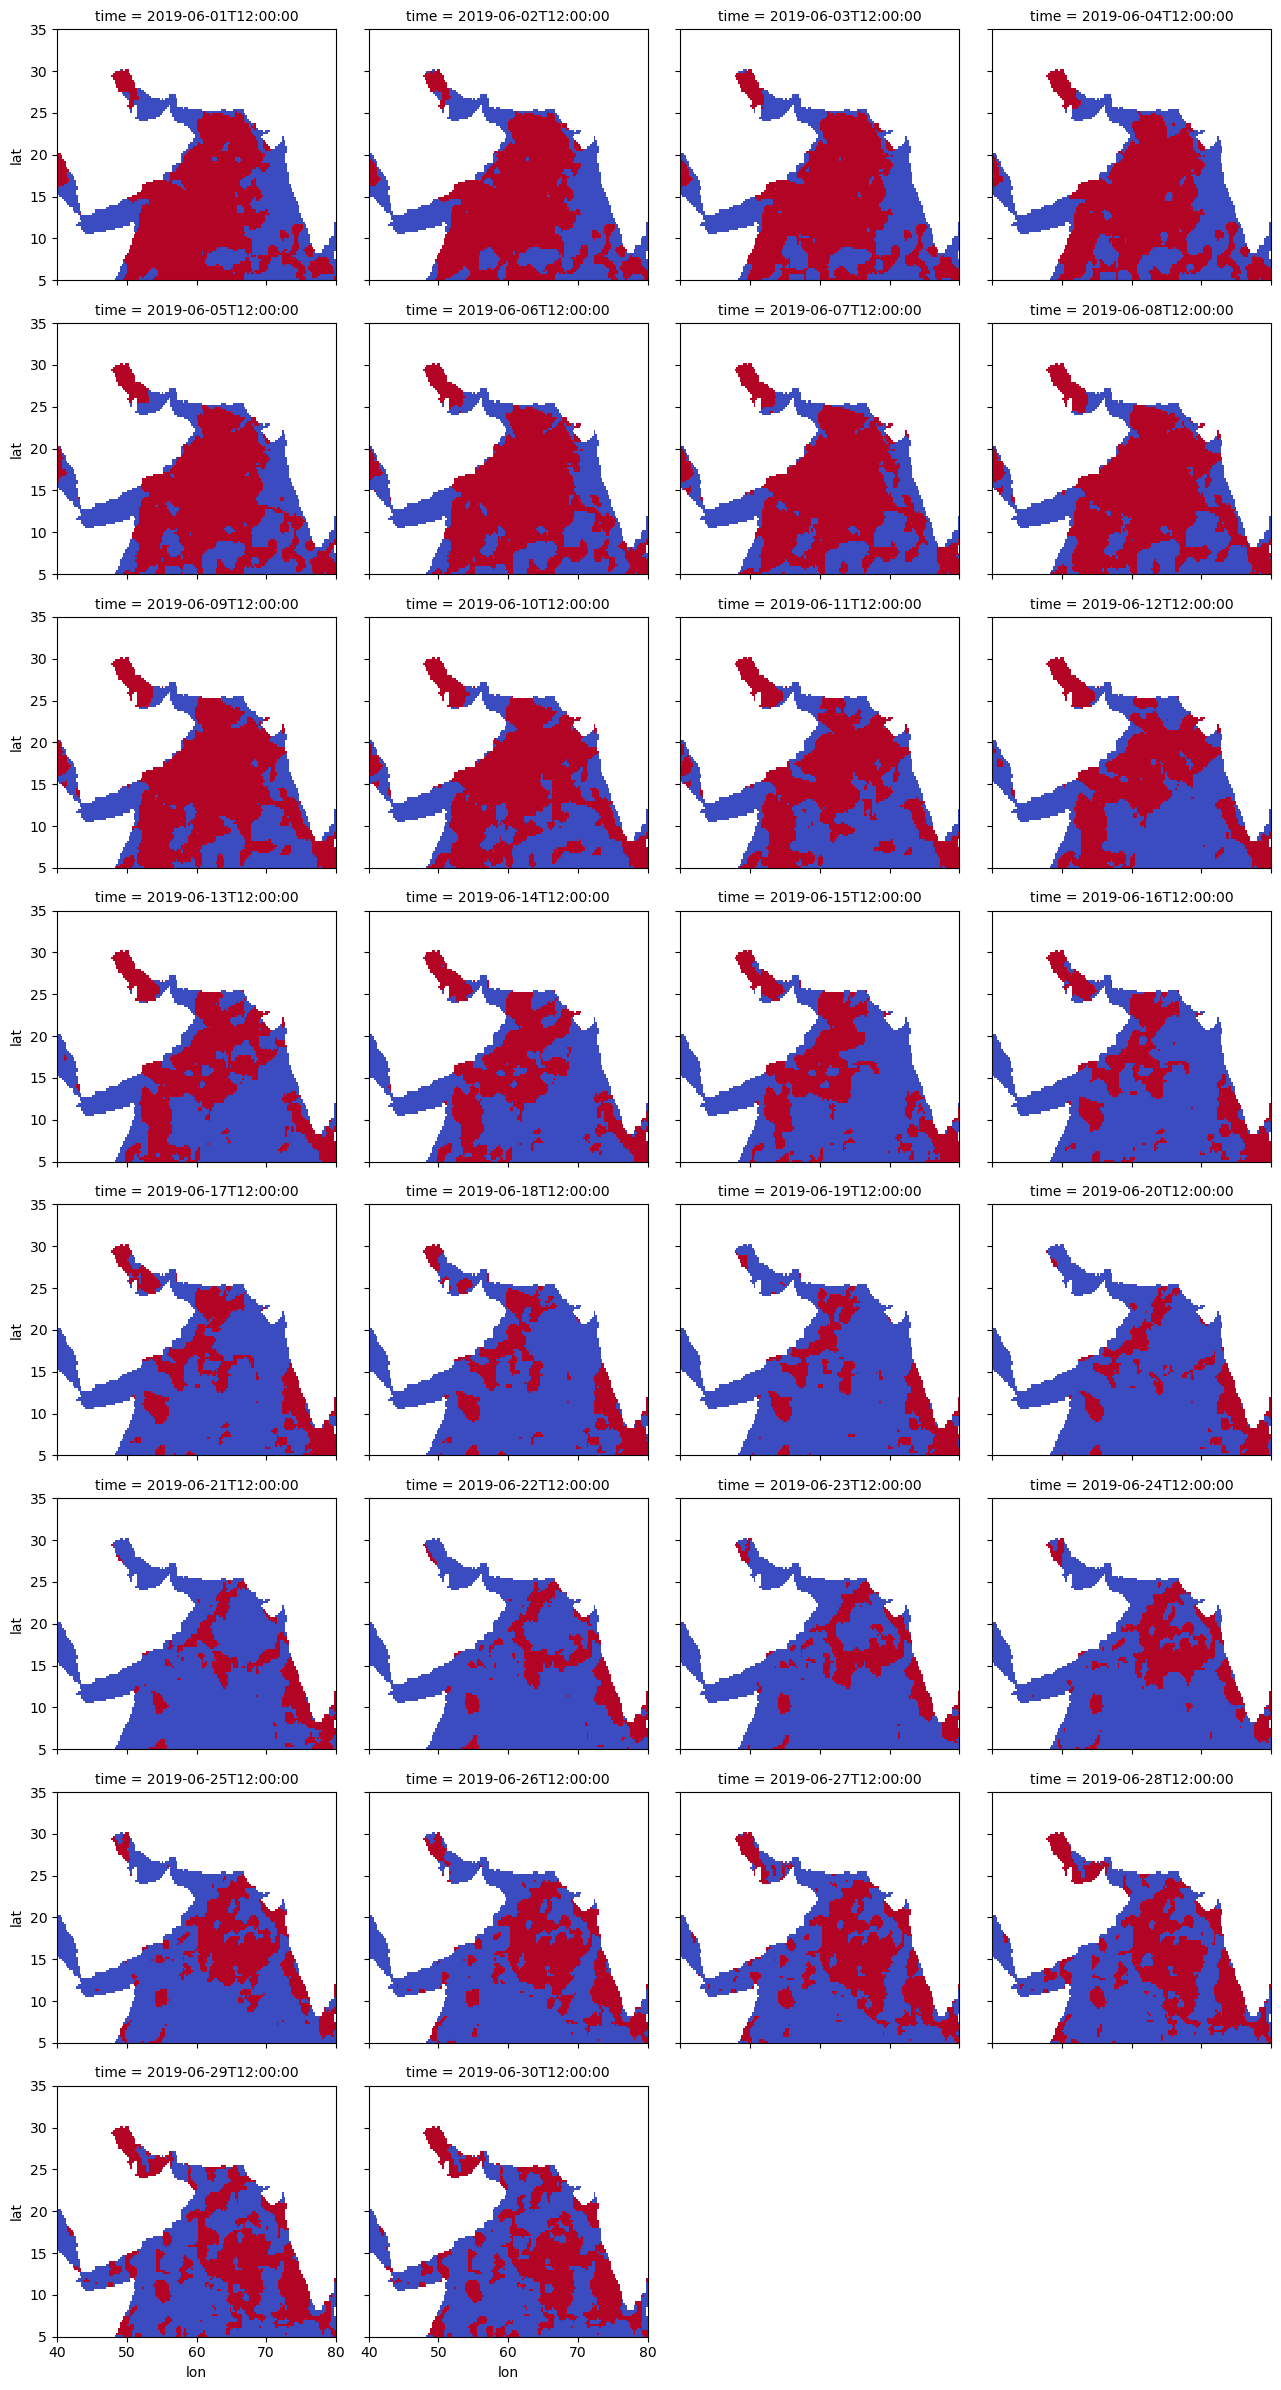

In [15]:
mhw.__xarray_dataarray_variable__.sel(time=slice("2019-06-01","2019-06-30"))  \
   .plot(cmap="coolwarm", col="time",col_wrap=4,add_colorbar=False)

In [8]:
mhw.__xarray_dataarray_variable__.isel(lat=10,lon=60).sel(time=slice('2012','2013')).values    ###This file contains 0 and 1s. 1s where MHWs are detected. There should be ateast 5 ones together.

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0.

In [10]:
climatology_90th_percentile_smoothed

<xarray.DataArray 'sst' (dayofyear: 366, lat: 120, lon: 160)> Size: 56MB
[7027200 values with dtype=float64]
Coordinates:
  * lon        (lon) float32 640B 40.12 40.38 40.62 40.88 ... 79.38 79.62 79.88
  * lat        (lat) float32 480B 5.125 5.375 5.625 5.875 ... 34.38 34.62 34.88
    quantile   float64 8B ...
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366